In [4]:
import joblib 
import catboost
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

BEST_MODEL_PATH = "../../../baselines/catboost/models/best_catboost_transynergy.pkl"
transynergy_gene_csv_path: str | None = "../../../external/drug_combination/data/genes/genes_2401_df.csv"

gene_df = pd.read_csv(transynergy_gene_csv_path)
gene_symbols = gene_df['symbol'].tolist()
feature_names_drugs_a = [f"{g}_A" for g in gene_symbols] + ["pIC50_A"]
feature_names_drugs_b = [f"{g}_B" for g in gene_symbols] + ["pIC50_B"]
feature_names_cell_lines = gene_df['symbol'].tolist() + ["padding_feature"]
FEATURE_NAMES = feature_names_drugs_a + feature_names_drugs_b + feature_names_cell_lines

sns.set_theme(style="whitegrid")

## Load model

In [5]:
model: catboost.CatBoostRegressor = joblib.load(BEST_MODEL_PATH)
model

## Load importances and interactions

In [6]:
feature_importances = np.array(model.feature_importances_)
fi_df = pd.DataFrame({
    'feature': FEATURE_NAMES,
    'importance': feature_importances
})

fi_df = fi_df.sort_values(by='importance', ascending=False)
fi_df.shape

(7206, 2)

In [7]:
fi_df.to_csv("catboost_feature_importances.csv")

In [8]:
interactions = model.get_feature_importance(type='Interaction') 
# Format is [[1st_feature_idx, 2nd_feature_idx, importance], ...]

n_features = len(FEATURE_NAMES)
interaction_matrix = np.zeros((n_features, n_features))

# Fill matrix
for i_flt, j_flt, score in interactions:
    i = int(i_flt)
    j = int(j_flt)
    interaction_matrix[i][j] = score

interaction_matrix.shape

(7206, 7206)

In [9]:
interaction_df = pd.DataFrame(interaction_matrix, columns=FEATURE_NAMES)
interaction_df.index = FEATURE_NAMES
interaction_df.head()
interaction_df.to_csv("catboost_feature_interactions.csv")

In [10]:
# TODO: add SHAP values, catboost library has method for it!

## Individual feature importances

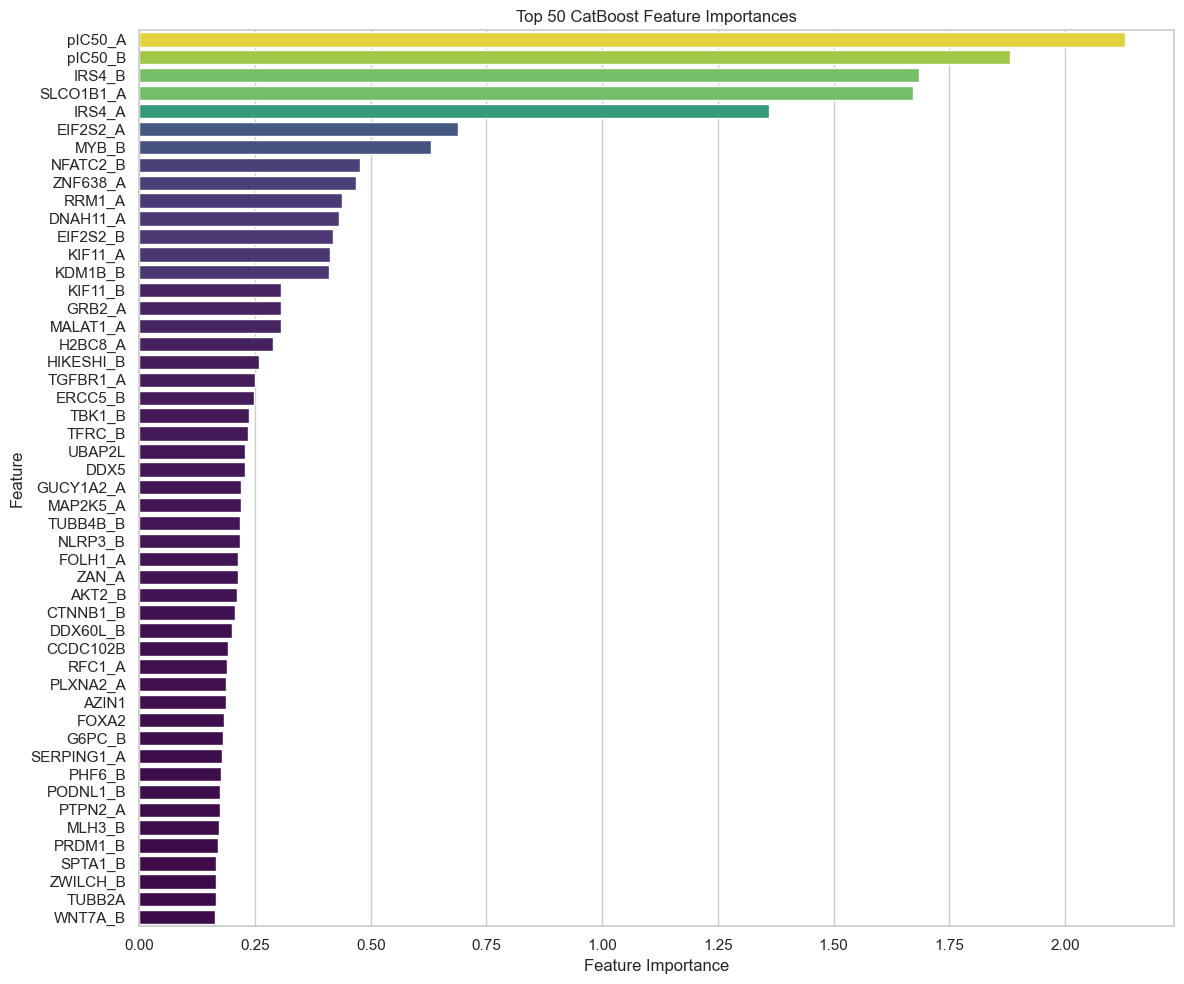

In [12]:
top_fi_df = fi_df.sort_values(by='importance', ascending=False).head(50)

plt.figure(figsize=(12, 10))  # Increase height for better readability
sns.barplot(
    data=top_fi_df,
    y='feature',
    x='importance',
    palette='viridis',
    hue='importance',
    legend=False
)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 50 CatBoost Feature Importances")
plt.tight_layout()
plt.savefig('top_50_feature_importances.png')
plt.show()

## Feature interaction heatmap

In [14]:
# Plot heatmap
## TOO MUCH DATA!
# plt.figure(figsize=(12, 10))
# sns.heatmap(interaction_matrix,
#             xticklabels=FEATURE_NAMES,
#             yticklabels=FEATURE_NAMES,
#             cmap='viridis',
#             square=True,
#             cbar_kws={'label': 'Interaction Importance'},
#             annot=False)

# plt.title('Feature Interaction Importance Heatmap')
# plt.tight_layout()
# plt.savefig('feature_interaction_heatmap.png')
# plt.show()

## Top 50 feature interactions

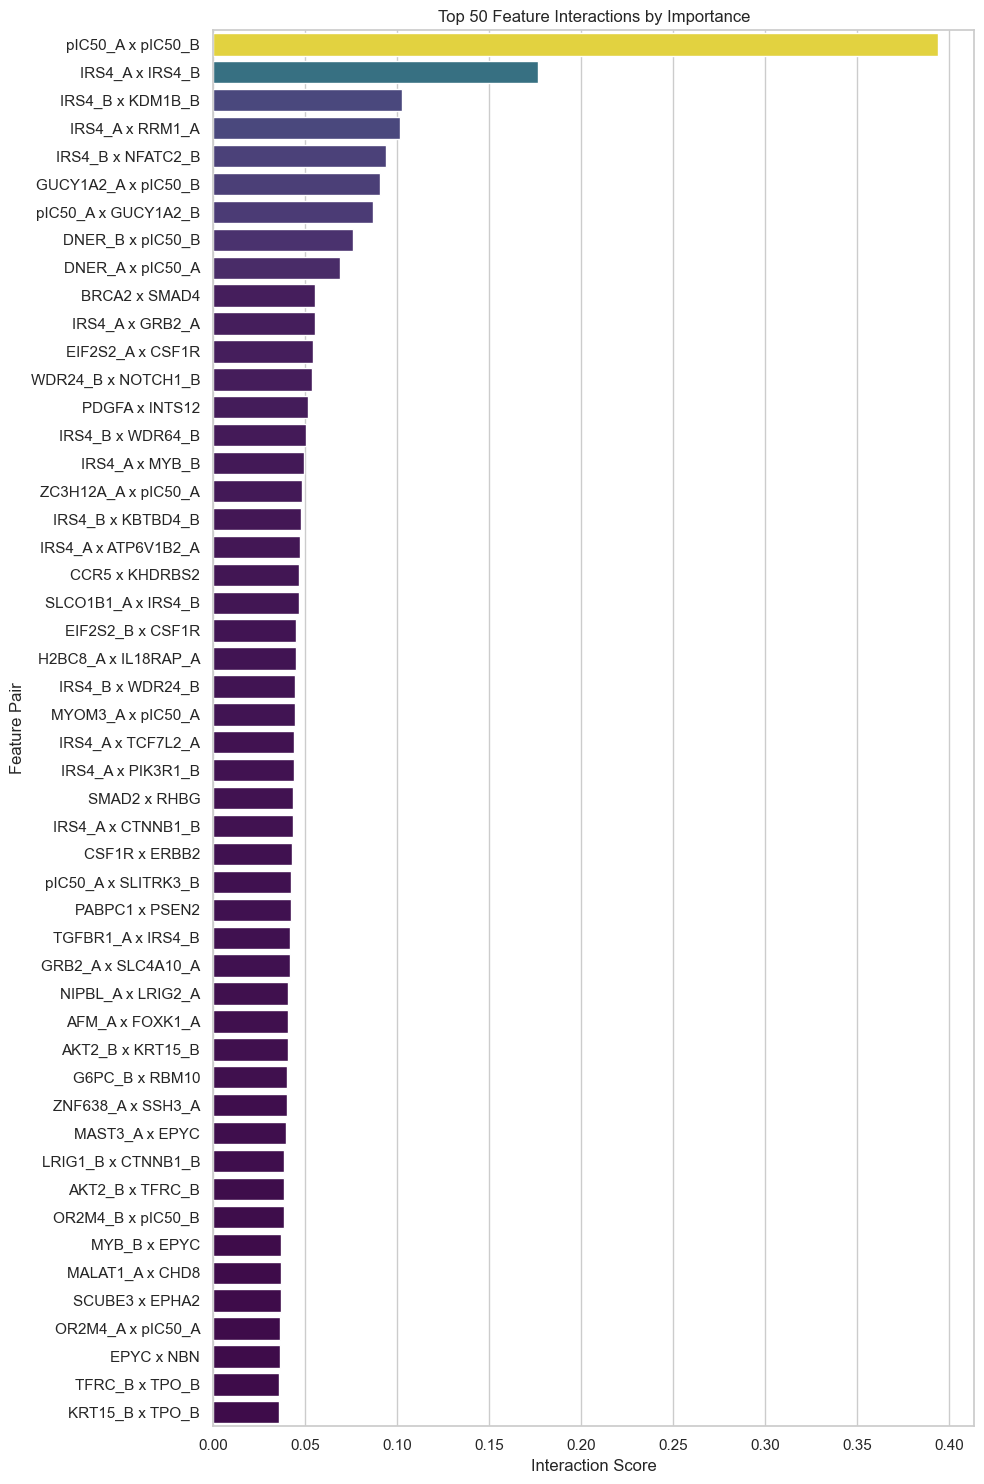

In [15]:
# Step 1: Sort by interaction score descending
sorted_interactions = sorted(interactions, key=lambda x: x[2], reverse=True)

# Step 2: Take top 50
top_k = 50
top_interactions = sorted_interactions[:top_k]

# Step 3: Convert to (name1, name2, score) tuples
named_interactions = [
    (f"{FEATURE_NAMES[int(i)]} x {FEATURE_NAMES[int(j)]}", score)
    for i, j, score in top_interactions
]

# Step 4: Separate for plotting
labels, scores = zip(*named_interactions)

# Step 5: Plot
plt.figure(figsize=(10, 15))
sns.barplot(x=scores, y=labels, palette='viridis', hue=scores, legend=False)

plt.xlabel("Interaction Score")
plt.ylabel("Feature Pair")
plt.title(f"Top {top_k} Feature Interactions by Importance")
plt.tight_layout()
plt.savefig('feature_interactions_top_50.png')
plt.show()